# Big Data Fundamentals with PySpark - Part 4

## Machine Learning with PySpark MLlib
PySpark MLlib is the Apache Spark scalable machine learning library in Python consisting of common learning algorithms and utilities. Throughout this last chapter, you'll learn important Machine Learning algorithms. You will build a movie recommendation engine and a spam filter, and use k-means clustering.

In [1]:
BUCKET = 'driven-actor-210609'

In [2]:
from pyspark.sql import SparkSession
from pyspark.mllib.recommendation import Rating
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.regression import LabeledPoint

from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### PySpark MLlib ML Algorithms
- Collaborative filtering: Alternating Least Squares (ALS)
- Classification (Binary and Multiclass) and Regression: Linear SVM, Logistic Regression, Decision Tree, Random Forest, Gradient-Boosted Tree, Naive Bayes, Linear Least Square, Lasso, Ridge Regression, Isotonic Regression
- Clustering: K-means, Gaussian Mixture, Power Iteration Clustering (PIC), Bisecting K-means, Streaming K-means

### PySpark MLlib Featurization
- feature extraction
- transformation
- dimensionality reduction
- selection

### PySpark MLlib Pipeline
- constructing pipelines
- evaluating pipelines
- tuning ML pipelines

### PySpark MLlib algorithms
Before using any Machine learning algorithms in PySpark shell, you'll have to import the submodules of pyspark.mllib library and then choose the appropriate class that is needed for a specific machine learning task.

In this simple exercise, you'll learn how to import the different submodules of pyspark.mllib along with the classes that are needed for performing Collaborative filtering, Classification and Clustering algorithms.

In [4]:
# Import the library for ALS
from pyspark.mllib.recommendation import ALS

# Import the library for Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# Import the library for Kmeans
from pyspark.mllib.clustering import KMeans

### Collaborative filtering

### Loading Movie Lens dataset into RDDs
Collaborative filtering is a technique for recommender systems wherein users' ratings and interactions with various products are used to recommend new ones. With the advent of Machine Learning and parallelized processing of data, Recommender systems have become widely popular in recent years, and are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags. In this 3-part exercise, your goal is to develop a simple movie recommendation system using PySpark MLlib using a subset of MovieLens 100k dataset.

In the first part, you'll first load the MovieLens data (ratings.csv) into RDD and from each line in the RDD which is formatted as userId,movieId,rating,timestamp, you'll need to map the MovieLens data to a Ratings object (userID, productID, rating) after removing timestamp column and finally you'll split the RDD into training and test RDDs.

Remember, you have a SparkContext sc available in your workspace. Also file_path variable (which is the path to the ratings.csv file), and ALS class are already available in your workspace.

In [5]:
file_path = f'gs://{BUCKET}/pyspark/datasets/ratings.csv'
# file_path = '../datasets/movieLens/ratings.csv'

# Load the data into RDD
data = sc.textFile(file_path)

# Extract header
header = data.first()

# Filter out header
data = data.filter(lambda x: x != header)

data.take(10)

['1,1029,3.0,1260759179',
 '1,1061,3.0,1260759182',
 '1,1129,2.0,1260759185',
 '1,1172,4.0,1260759205',
 '1,1263,2.0,1260759151',
 '1,1287,2.0,1260759187',
 '1,1293,2.0,1260759148',
 '1,1339,3.5,1260759125',
 '1,1343,2.0,1260759131',
 '1,1371,2.5,1260759135']

In [6]:
# Split the RDD
ratings = data.map(lambda l: l.split(','))

ratings.take(10)

[['1', '1029', '3.0', '1260759179'],
 ['1', '1061', '3.0', '1260759182'],
 ['1', '1129', '2.0', '1260759185'],
 ['1', '1172', '4.0', '1260759205'],
 ['1', '1263', '2.0', '1260759151'],
 ['1', '1287', '2.0', '1260759187'],
 ['1', '1293', '2.0', '1260759148'],
 ['1', '1339', '3.5', '1260759125'],
 ['1', '1343', '2.0', '1260759131'],
 ['1', '1371', '2.5', '1260759135']]

In [7]:
# Transform the ratings RDD
ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))

ratings_final.take(10)

[Rating(user=1, product=1029, rating=3.0),
 Rating(user=1, product=1061, rating=3.0),
 Rating(user=1, product=1129, rating=2.0),
 Rating(user=1, product=1172, rating=4.0),
 Rating(user=1, product=1263, rating=2.0),
 Rating(user=1, product=1287, rating=2.0),
 Rating(user=1, product=1293, rating=2.0),
 Rating(user=1, product=1339, rating=3.5),
 Rating(user=1, product=1343, rating=2.0),
 Rating(user=1, product=1371, rating=2.5)]

In [8]:
# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])

print(f"Total number of data: {ratings_final.count()}, number of training data: {training_data.count()}, number to test data: {test_data.count()}.")

Total number of data: 100003, number of training data: 79766, number to test data: 20237.


### Model training and predictions
After splitting the data into training and test data, in the second part of the exercise, you'll train the ALS algorithm using the training data. PySpark MLlib's ALS algorithm has the following mandatory parameters - rank (the number of latent factors in the model) and iterations (number of iterations to run). After training the ALS model, you can use the model to predict the ratings from the test data. For this, you will provide the user and item columns from the test dataset and finally return the list of 2 rows of predictAll() output.

Remember, you have SparkContext sc, training_data and test_data are already available in your workspace.

In [9]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=10)

print(type(model))

<class 'pyspark.mllib.recommendation.MatrixFactorizationModel'>


In [10]:
# Drop the ratings column
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))

# Predict the model
predictions = model.predictAll(testdata_no_rating)

# Return the first 2 rows of the RDD
predictions.take(2)

[Rating(user=580, product=1084, rating=3.3418881552327298),
 Rating(user=548, product=1084, rating=3.797123470893869)]

### Model evaluation using MSE
After generating the predicted ratings from the test data using ALS model, in this final part of the exercise, you'll prepare the data for calculating Mean Square Error (MSE) of the model. The MSE is the average value of (original rating – predicted rating)**2 for all users and indicates the absolute fit of the model to the data. To do this, first, you'll organize both the ratings and prediction RDDs to make a tuple of ((user, product), rating)), then join the ratings RDD with prediction RDD and finally apply a squared difference function along with mean() to get the MSE.

Remember, you have a SparkContext sc available in your workspace. Also, ratings_final and predictions RDD are already available in your workspace.

In [11]:
# Prepare ratings data
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))

rates.take(10)

[((1, 1029), 3.0),
 ((1, 1061), 3.0),
 ((1, 1129), 2.0),
 ((1, 1172), 4.0),
 ((1, 1263), 2.0),
 ((1, 1287), 2.0),
 ((1, 1293), 2.0),
 ((1, 1339), 3.5),
 ((1, 1343), 2.0),
 ((1, 1371), 2.5)]

In [12]:
# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))

preds.take(10)

[((580, 1084), 3.3418881552327298),
 ((548, 1084), 3.797123470893869),
 ((558, 1084), 4.39857420830479),
 ((182, 1084), 2.8505241031204998),
 ((436, 1084), 3.9161212328784574),
 ((86, 1084), 2.5200037334721817),
 ((358, 1084), 4.053915064249604),
 ((564, 1084), 4.863609982893283),
 ((547, 1084), 4.105798443745432),
 ((505, 1084), 3.079467868336085)]

In [15]:
# Join the ratings data with predictions data
rates_and_preds = rates.join(preds)

rates_and_preds.take(10)

[((1, 1061), (3.0, 4.115997064855809)),
 ((1, 1293), (2.0, 0.19526084036776403)),
 ((1, 2105), (4.0, 2.6812640941664014)),
 ((2, 292), (3.0, 2.2513794904810824)),
 ((2, 296), (4.0, 3.7946060658799903)),
 ((2, 552), (3.0, 4.4360616466942915)),
 ((3, 247), (3.5, 4.281280443957527)),
 ((3, 527), (3.0, 4.392305901891133)),
 ((3, 595), (2.0, 3.834745590590537)),
 ((3, 58559), (3.0, 4.251449405270887))]

In [16]:
# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1]) ** 2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.35


### Classification

### Loading spam and non-spam data
Logistic Regression is a popular method to predict a categorical response. Probably one of the most common applications of the logistic regression is the message or email spam classification. In this 3-part exercise, you'll create an email spam classifier with logistic regression using Spark MLlib. Here are the brief steps for creating a spam classifier.

Create an RDD of strings representing email.
Run MLlib’s feature extraction algorithms to convert text into an RDD of vectors.
Call a classification algorithm on the RDD of vectors to return a model object to classify new points.
Evaluate the model on a test dataset using one of MLlib’s evaluation functions.
In the first part of the exercise, you'll load the 'spam' and 'ham' (non-spam) files into RDDs, split the emails into individual words and look at the first element in each of the RDD.

Remember, you have a SparkContext sc available in your workspace. Also file_path_spam variable (which is the path to the 'spam' file) and file_path_non_spam (which is the path to the 'non-spam' file) is already available in your workspace.

In [17]:
file_path_spam = f'gs://{BUCKET}/pyspark/datasets/spam.txt'
# file_path_spam = '../datasets/spam/spam.txt'

# Load the dataset into RDDs
spam_rdd = sc.textFile(file_path_spam)

spam_rdd.take(10)

['You have 1 new message. Please call 08712400200.',
 'Urgent! Please call 09061743811 from landline. Your ABTA complimentary 4* Tenerife Holiday or £5000 cash await collection SAE T&Cs Box 326 CW25WX 150ppm',
 "Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs",
 'U 447801259231 have a secret admirer who is looking 2 make contact with U-find out who they R*reveal who thinks UR so special-call on 09058094597',
 'Congrats! 2 mobile 3G Videophones R yours. call 09061744553 now! videochat wid ur mates, play java games, Dload polyH music, noline rentl. bx420. ip4. 5we. 150pm',
 'PRIVATE! Your 2003 Account Statement for 07815296484 shows 800 un-redeemed S.I.M. points. Call 08718738001 Identifier Code 41782 Expires 18/11/04',
 'Do you want a new video handset? 750 anytime any network mins? Half Price Line Rental? Camcorder? Reply or call 08000930705 for delivery tomorrow',
 'Money i have 

In [18]:
file_path_non_spam = f'gs://{BUCKET}/pyspark/datasets/ham.txt'
# file_path_non_spam = '../datasets/spam/ham.txt'

# Load the dataset into RDDs
non_spam_rdd = sc.textFile(file_path_non_spam)

non_spam_rdd.take(10)

['Rofl. Its true to its name',
 "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
 'Pity, * was in mood for that. So...any other suggestions?',
 'Will ü b going to esplanade fr home?',
 'Huh y lei...',
 "Why don't you wait 'til at least wednesday to see if you get your .",
 'Ard 6 like dat lor.',
 'Ok lor... Sony ericsson salesman... I ask shuhui then she say quite gd 2 use so i considering...',
 'Get me out of this dump heap. My mom decided to come to lowes. BORING.',
 'Anything lor. Juz both of us lor.']

In [19]:
# Split the email messages into words
spam_words = spam_rdd.flatMap(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(' '))

# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


## Feature hashing and LabelPoint
After splitting the emails into words, our raw data set of 'spam' and 'non-spam' is currently composed of 1-line messages consisting of spam and non-spam messages. In order to classify these messages, we need to convert text into features.

In the second part of the exercise, you'll first create a HashingTF() instance to map text to vectors of 200 features, then for each message in 'spam' and 'non-spam' files you'll split them into words, and each word is mapped to one feature. These are the features that will be used to decide whether a message is 'spam' or 'non-spam'. Next, you'll create labels for features. For a valid message, the label will be 0 (i.e. the message is not spam) and for a 'spam' message, the label will be 1 (i.e. the message is spam). Finally, you'll combine both the labeled datasets.

Remember, you have a SparkContext sc available in your workspace. Also spam_words and non_spam_words variables are already available in your workspace.

In [20]:
# Create a HashingTf instance with 200 features
tf = HashingTF(numFeatures=200)

print(type(tf))

<class 'pyspark.mllib.feature.HashingTF'>


In [21]:
# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

print(type(spam_features))

<class 'pyspark.rdd.PipelinedRDD'>


In [22]:
# Preview spam features
spam_features.take(10)

[SparseVector(200, {75: 1.0, 150: 1.0, 183: 1.0}),
 SparseVector(200, {1: 1.0, 19: 1.0, 165: 1.0, 169: 1.0}),
 SparseVector(200, {197: 1.0}),
 SparseVector(200, {1: 1.0, 19: 1.0, 125: 1.0}),
 SparseVector(200, {1: 2.0, 19: 1.0, 35: 1.0, 56: 1.0, 117: 2.0, 192: 1.0}),
 SparseVector(200, {1: 2.0, 19: 1.0, 44: 1.0, 61: 1.0, 117: 1.0}),
 SparseVector(200, {19: 1.0, 44: 2.0, 162: 1.0}),
 SparseVector(200, {56: 1.0, 63: 1.0, 78: 5.0, 85: 2.0, 168: 1.0, 194: 1.0, 197: 1.0}),
 SparseVector(200, {1: 1.0, 79: 1.0, 104: 1.0, 120: 1.0, 125: 1.0, 192: 1.0, 196: 1.0}),
 SparseVector(200, {1: 2.0, 19: 1.0, 44: 1.0, 61: 1.0, 117: 1.0})]

In [24]:
# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features: LabeledPoint(label=1, features=features))
non_spam_samples = non_spam_features.map(lambda features: LabeledPoint(label=0, features=features))

spam_samples.take(10)

[LabeledPoint(1.0, (200,[75,150,183],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,165,169],[1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[197],[1.0])),
 LabeledPoint(1.0, (200,[1,19,125],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,35,56,117,192],[2.0,1.0,1.0,1.0,2.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,44,61,117],[2.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[19,44,162],[1.0,2.0,1.0])),
 LabeledPoint(1.0, (200,[56,63,78,85,168,194,197],[1.0,1.0,5.0,2.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,79,104,120,125,192,196],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,44,61,117],[2.0,1.0,1.0,1.0,1.0]))]

In [27]:
# Combine the two datasets
samples = spam_samples.union(non_spam_samples)

samples.take(10)

[LabeledPoint(1.0, (200,[75,150,183],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,165,169],[1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[197],[1.0])),
 LabeledPoint(1.0, (200,[1,19,125],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,35,56,117,192],[2.0,1.0,1.0,1.0,2.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,44,61,117],[2.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[19,44,162],[1.0,2.0,1.0])),
 LabeledPoint(1.0, (200,[56,63,78,85,168,194,197],[1.0,1.0,5.0,2.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,79,104,120,125,192,196],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,44,61,117],[2.0,1.0,1.0,1.0,1.0]))]

### Logistic Regression model training
After creating labels and features for the data, we’re ready to build a model that can learn from it (training). But before you train the model, in this final part of the exercise, you'll split the data into training and test, run Logistic Regression model on the training data, and finally check the accuracy of the model trained on training data.

Remember, you have a SparkContext sc available in your workspace, as well as the samples variable.

In [28]:
# Split the data into training and testing
train_samples, test_samples = samples.randomSplit([0.8, 0.2])

# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples)

# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))

# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

25/02/28 18:36:35 WARN Instrumentation: [b82d3b66] Initial coefficients will be ignored! Its dimensions (1, 200) did not match the expected size (1, 200)


Model accuracy : 0.81


### Clustering

### Loading and parsing the 5000 points data
Clustering is the unsupervised learning task that involves grouping objects into clusters of high similarity. Unlike the supervised tasks, where data is labeled, clustering can be used to make sense of unlabeled data. PySpark MLlib includes the popular K-means algorithm for clustering. In this 3 part exercise, you'll find out how many clusters are there in a dataset containing 5000 rows and 2 columns. For this you'll first load the data into an RDD, parse the RDD based on the delimiter, run the KMeans model, evaluate the model and finally visualize the clusters.

In the first part, you'll load the data into RDD, parse the RDD based on the delimiter and convert the string type of the data to an integer.

Remember, you have a SparkContext sc available in your workspace. Also file_path variable (which is the path to the 5000_points.txt file) is already available in your workspace.

In [31]:
file_path = f'gs://{BUCKET}/pyspark/datasets/5000_points.txt'
# file_path = '../datasets/points/5000_points.txt'

# Load the dataset into an RDD
clusterRDD = sc.textFile(file_path)

clusterRDD.take(10)

['664159\t550946',
 '665845\t557965',
 '597173\t575538',
 '618600\t551446',
 '635690\t608046',
 '588100\t557588',
 '582015\t546191',
 '604678\t574577',
 '572029\t518313',
 '604737\t574591']

In [32]:
# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split('\t'))

rdd_split.take(10)

[['664159', '550946'],
 ['665845', '557965'],
 ['597173', '575538'],
 ['618600', '551446'],
 ['635690', '608046'],
 ['588100', '557588'],
 ['582015', '546191'],
 ['604678', '574577'],
 ['572029', '518313'],
 ['604737', '574591']]

In [33]:
# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])

rdd_split_int.take(10)

[[664159, 550946],
 [665845, 557965],
 [597173, 575538],
 [618600, 551446],
 [635690, 608046],
 [588100, 557588],
 [582015, 546191],
 [604678, 574577],
 [572029, 518313],
 [604737, 574591]]

In [34]:
# Count the number of rows in RDD
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


### K-means training
Now that the RDD is ready for training, in this 2nd part, you'll test with k's from 13 to 16 (to save computation time) and use the elbow method to chose the correct k. The idea of the elbow method is to run K-means clustering on the dataset for different values of k, calculate Within Set Sum of Squared Error (WSSSE) and select the best k based on the sudden drop in WSSSE. Next, you'll retrain the model with the best k and finally, get the centroids (cluster centers).

Remember, you already have a SparkContext sc and rdd_split_int RDD available in your workspace.

In [35]:
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [37]:
# Train the model with clusters from 13 to 16 and compute WSSSE
for clst in range(13, 17):
    model = KMeans.train(rdd=rdd_split_int, k=clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))

The cluster 13 has Within Set Sum of Squared Error 252060331.1260039


The cluster 14 has Within Set Sum of Squared Error 215808893.2796594


The cluster 15 has Within Set Sum of Squared Error 169394691.52639425
The cluster 16 has Within Set Sum of Squared Error 168103213.0429197


In [40]:
# Train the model again with the best k
model = KMeans.train(rdd=rdd_split_int, k=15, seed=1)

# Get cluster centers
cluster_centers = model.clusterCenters

cluster_centers

[array([417799.69426752, 787001.99363057]),
 array([852058.45259939, 157685.52293578]),
 array([858947.9713467 , 546259.65902579]),
 array([398555.94857143, 404855.06857143]),
 array([507818.31339031, 175610.41595442]),
 array([167856.14071856, 347812.71556886]),
 array([337565.11890244, 562157.17682927]),
 array([139682.37572254, 558123.40462428]),
 array([320602.55, 161521.85]),
 array([244654.8856305 , 847642.04105572]),
 array([801616.78164557, 321123.34177215]),
 array([606574.95622896, 574455.16835017]),
 array([823421.2507837 , 731145.27272727]),
 array([617601.91071429, 399504.21428571]),
 array([670929.06818182, 862765.73295455])]

### Visualizing clusters
You just trained the k-means model with an optimum k value (k=15) and generated cluster centers (centroids). In this final exercise, you will visualize the clusters and the centroids by overlaying them. This will indicate how well the clustering worked (ideally, the clusters should be distinct from each other and centroids should be at the center of their respective clusters).

To achieve this, you will first convert the rdd_split_int RDD into a Spark DataFrame, and then into Pandas DataFrame which can be used for plotting. Similarly, you will convert cluster_centers into a Pandas DataFrame. Once both the DataFrames are created, you will create scatter plots using Matplotlib.

The SparkContext sc as well as the variables rdd_split_int and cluster_centers are available in your workspace.

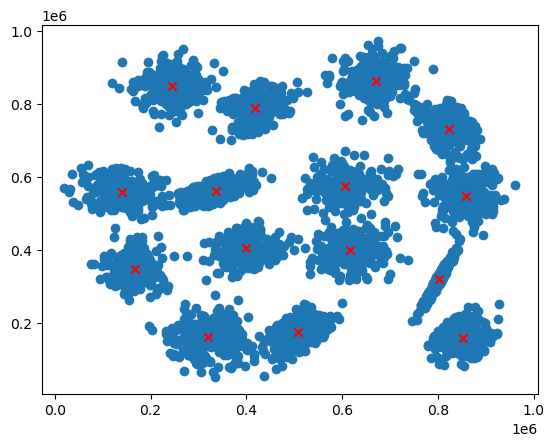

In [41]:
# Convert rdd_split_int RDD into Spark DataFrame and then to Pandas DataFrame
rdd_split_int_df_pandas = spark.createDataFrame(rdd_split_int, schema=["col1", "col2"]).toPandas()

# Convert cluster_centers to a pandas DataFrame
cluster_centers_pandas = pd.DataFrame(cluster_centers, columns=["col1", "col2"])

# Create an overlaid scatter plot of clusters and centroids
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()